In [1]:
import sys
sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
from easydict import EasyDict as edict

import os
import copy
import torch

from vision_base.utils.builder import build
from vision_base.data.datasets.dataset_utils import collate_fn
from vision_base.utils.utils import cfg_from_file
from vision_base.networks.utils.utils import load_models
from mono3d.model.utils import BBox3dProjector, BackProjection
from mono3d.evaluation.utils import draw_3D_box

print('CUDA available: {}'.format(torch.cuda.is_available()))


cfg = cfg_from_file("/home/yliuhb/vision_collection/model/det3d/monoflex_cfg.py")
is_test_train = True

checkpoint_name = "/home/yliuhb/vision_collection/model/det3d/monoflex.pth"

CUDA available: True


In [2]:
index = 0
cfg.batch_size=1
cfg.trainer.gpu=0
cfg.meta_arch.network_cfg.head.test_cfg.score_thr=0.3
torch.cuda.set_device(cfg.trainer.gpu)

augmentation_lib = 'vision_base.data.augmentations.augmentations'
builder_lib = 'vision_base.utils.builder'
demo_dataset_cfg = edict(
    name = "mono3d.data.dataset.JsonTestDataset",
    # name = "mono3d.data.dataset.DGPTestDataset",
    main_calibration_key='P2',
    json_path = os.path.join(cfg.path.base_path, 'nusc_object.json'),
    # json_path = '/data/ddad_train_val/ddad.json',
    augmentation = edict(
    name=f'{builder_lib}.Sequential',
    cfg_list=[
            edict(name=f'{augmentation_lib}.ConvertToFloat'),
            edict(name=f'{augmentation_lib}.Resize', size=(384, 1280), preserve_aspect_ratio=True, force_pad=True),
            edict(name=f'{augmentation_lib}.Normalize', mean=cfg.data.augmentation.rgb_mean, stds=cfg.data.augmentation.rgb_std),
            edict(name=f'{augmentation_lib}.ConvertToTensor'),
    ],
    image_keys=['image'],
    calib_keys=['P'],
    )
)

dataset = build(**demo_dataset_cfg)

In [6]:
meta_arch = build(**cfg.meta_arch)
meta_arch = meta_arch.cuda()
weight_path = checkpoint_name
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))

meta_arch.load_state_dict(state_dict['model_state_dict'], strict=False)
meta_arch.eval();

projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

test_hook = build(**cfg.trainer.evaluate_hook.test_run_hook_cfg)

{'hm_loss': 1, 'hp_loss': 1, 'box2d_loss': 1, 'off_loss': 0.5, 'dim_loss': 1, 'depth_loss': 1, 'kpd_loss': 0.2, 'rot_loss': 0.2, 'soft_depth_loss': 0.2}
http://dl.yf.io/dla/models/imagenet/dla34-ba72cf86.pth


Downloading: "http://dl.yf.io/dla/models/imagenet/dla34-ba72cf86.pth" to /root/.cache/torch/hub/checkpoints/dla34-ba72cf86.pth
100%|██████████| 60.3M/60.3M [00:27<00:00, 2.30MB/s]


Apply DLA Upsampling instead, feature_size=64


In [3]:
['car', 'truck', 'bus', 'trailer', 'construction_vehicle', 'pedestrian', 'motorcycle', 'bicycle', 'traffic_cone', 'barrier']
color_mapping = {
    'car' : (  0,  0,142),  'truck': (  0,  0, 70) , 'bus': (  0, 60,100), 'trailer': (  0,  0,110), 'construction_vehicle':  (  0,  0, 70), 'pedestrian': (220, 20, 60), 'motorcycle': (  0,  0,230),
    'bicycle': (119, 11, 32), 'traffic_cone': (180,165,180), 'barrier': (190,153,153)
}
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

def draw_four_side(bbox, *args, **kwargs):
    for box in bbox:
        for i in range(3):
            plt.plot(box[[0,1,2,3,0], 0], box[[0,1,2,3,0], 1], *args, **kwargs)
    

def draw_bev(state_3d, P2, *args, **kwargs):
    bbox_3d_state_3d = backprojector(state_3d, P2) #[x, y, z, w,h ,l, alpha]
    abs_bbox, _, _ = projector(bbox_3d_state_3d, bbox_3d_state_3d.new(P2))
    bev_bbox = abs_bbox[:, [0,1,4,5]][..., [0,2]]
    
    draw_four_side(bev_bbox.cpu().numpy(), *args, **kwargs)

    index = 0

def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

def process_score(scores, cx, cy, h, w):
    abs_scores = scores.abs().mean(dim=0) 
    HW, HW = abs_scores.shape
    alpha = 1.0
    cyw = int(cy * w)
    print(cx, cy, cyw, h, w)
    score = abs_scores[int(cx + cyw)] + alpha * (abs_scores[int(cx + 1 + cyw)] + 
                                                 abs_scores[int(cx - 1 + cyw)] + 
                                                 abs_scores[int(cx + w + cyw)] + 
                                                 abs_scores[int(cx - w + cyw)])
    score = score.reshape(h, w)
    return score

In [4]:
def denorm(image):
    new_image = np.clip((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, 0, 255)
    new_image = np.array(new_image, dtype=np.uint8)
    return new_image

    
def compute_once(index, is_draw=True):
    data = dataset[index]
    collated_data = collate_fn([data])
    image = collated_data['image']
    P2 = collated_data['P'][0]
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    with torch.no_grad():
        output_dict = test_hook(collated_data, meta_arch)
        scores = output_dict['scores']
        bboxes = output_dict['bboxes']
        cls_names = output_dict['cls_names']
    
    
    bbox_2d = bboxes[:, 0:4]
    print(bbox_2d, cls_names)
    if bboxes.shape[1] > 4:
        bbox_3d_state = bboxes[:, 4:] #[x, y,z,w,h,l,alpha, theta]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state, P2.cuda())
        
    if is_draw:
        rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
        if len(scores) > 0:
            rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
            if bboxes.shape[1] > 4:
                for i, box in enumerate(bbox_3d_corner_homo):
                    box = box.cpu().numpy().T
                    rgb_image = draw_3D_box(rgb_image.copy(), box, color=color_mapping[cls_names[i]])
                #print(torch.cat([bbox_3d_state[:,0:0], bbox_3d_state[:,:]], dim=1) )
            
        h, w = collated_data[('image_resize', 'effective_size')][0]
        print(h, w)
        plt.imshow(np.clip(rgb_image[0:h, 0:w], 0, 255))
        #plt.imshow(np.clip(rgb_image, 0, 255))
    return (np.clip(rgb_image, 0, 255))

tensor([[127.6645, 154.2177, 324.9643, 281.1308],
        [ 11.9271, 161.9875, 221.4369, 271.7498],
        [339.2589, 168.2966, 395.6613, 206.9455],
        [387.4275, 171.8497, 443.3247, 203.4540],
        [432.0077, 169.9117, 478.1652, 201.0686]], device='cuda:0') ['car', 'car', 'car', 'car', 'car']
tensor(384, device='cuda:0', dtype=torch.int32) tensor(683, device='cuda:0', dtype=torch.int32)


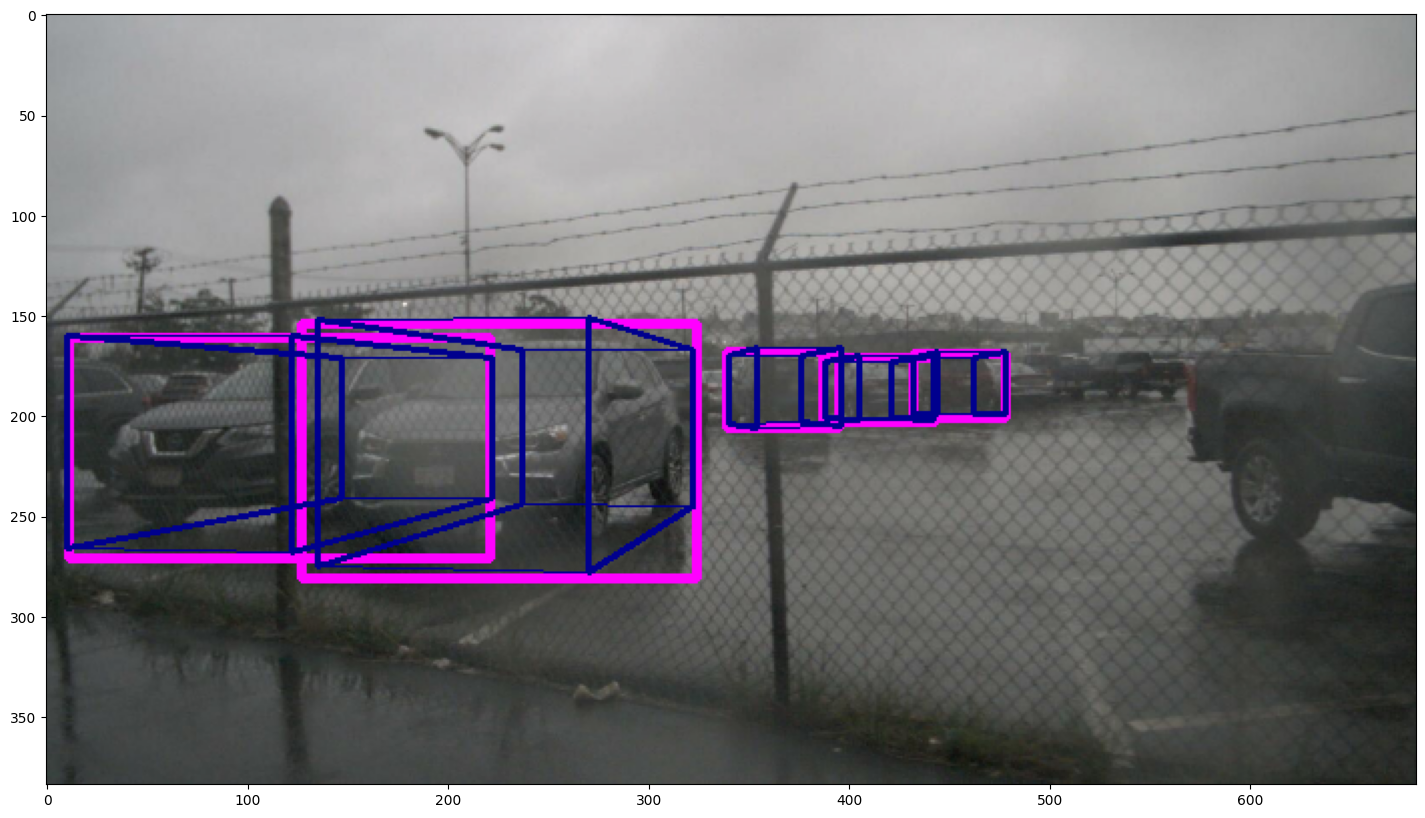

In [9]:
fig = plt.figure(figsize=(25, 10))
index = np.random.randint(0, len(dataset))
_ = compute_once(index);